# Rolling Planning mit Lateness (Tardiness + Earliness)

In [2]:
max_time = 60*45 # 1h

In [3]:
import time

from ortools.sat.python import cp_model
import pandas as pd
import numpy as np
import math

pd.set_option('display.max_rows', 20)


import utils.presenter as show
import utils.checker as check

import utils.scheduling_solver as ssv
import utils.rescheduling_solver_lateness as rssv

import utils.rolling_planning.init_jobs_times as rp_init
import utils.rolling_planning.procedure as rp_proced
import utils.schedule_deadline as deadline_gen

from ProductionDaySimulation import ProductionDaySimulation

In [4]:
start_notebook = time.time()

In [5]:
def get_schedule_filename(prefix: str = "", day: int = 0, data_txt: str = "schedule", suffix: str = "") -> str:
    file_template = "data/{prefix}_{data}_{day:02d}{suffix}.csv"
    if suffix:
        suffix = f"_{suffix}"
    return file_template.format(prefix=prefix,data=data_txt,day=day, suffix=suffix)

## Generierung des Datensatzes für 16 Tage (Ankunft)

In [7]:
days_numb = 16

In [8]:
df_instance = pd.read_csv("data/00_instance.csv")

df_jssp, df_arrivals = rp_init.init_jobs_with_arrivals(df_instance, days_numb,  u_b_mmax = 0.95)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
3035,Job_303,5,M9,76
3036,Job_303,6,M5,47
3037,Job_303,7,M3,52
3038,Job_303,8,M4,90


In [9]:
# Deadlines + Umwandlung in Integer
df_times = deadline_gen.get_times_df(df_jssp, df_arrivals, ssv.schedule_fcfs_with_arrivals, target_service=1, buffer_factor = 1)
df_times["Arrival"] = np.floor(df_times["Arrival"]).astype(int)
df_times["Deadline"] = np.ceil(df_times["Deadline"]).astype(int) # + 480
df_times

,Job,Arrival,Deadline
0,Job_000,0,1171
1,Job_001,83,1595
2,Job_002,144,1828
3,Job_003,197,2138
4,Job_004,233,1398
...,...,...,...
299,Job_299,22728,24669
300,Job_300,22734,23899
301,Job_301,22735,24419
302,Job_302,22854,24025


In [10]:
processing_time = df_jssp.groupby('Job')['Processing Time'].sum().reset_index()

df_times = pd.merge(df_times, processing_time, on='Job')
df_times 

,Job,Arrival,Deadline,Processing Time
0,Job_000,0,1171,395
1,Job_001,83,1595,510
2,Job_002,144,1828,568
3,Job_003,197,2138,655
4,Job_004,233,1398,393
...,...,...,...,...
299,Job_299,22728,24669,655
300,Job_300,22734,23899,393
301,Job_301,22735,24419,568
302,Job_302,22854,24025,395


In [11]:
df_times['Rounded Arrival'] = ((df_times['Arrival'] // 1440) + 1) * 1440
df_times

,Job,Arrival,Deadline,Processing Time,Rounded Arrival
0,Job_000,0,1171,395,1440
1,Job_001,83,1595,510,1440
2,Job_002,144,1828,568,1440
3,Job_003,197,2138,655,1440
4,Job_004,233,1398,393,1440
...,...,...,...,...,...
299,Job_299,22728,24669,655,23040
300,Job_300,22734,23899,393,23040
301,Job_301,22735,24419,568,23040
302,Job_302,22854,24025,395,23040


In [12]:
df_times['Slack'] = df_times['Deadline'] - (df_times['Rounded Arrival'] + df_times['Processing Time'])
df_times 

,Job,Arrival,Deadline,Processing Time,Rounded Arrival,Slack
0,Job_000,0,1171,395,1440,-664
1,Job_001,83,1595,510,1440,-355
2,Job_002,144,1828,568,1440,-180
3,Job_003,197,2138,655,1440,43
4,Job_004,233,1398,393,1440,-435
...,...,...,...,...,...,...
299,Job_299,22728,24669,655,23040,974
300,Job_300,22734,23899,393,23040,466
301,Job_301,22735,24419,568,23040,811
302,Job_302,22854,24025,395,23040,590


In [13]:
df_times.loc[df_times['Slack'].idxmax()]

Job                Job_018
Arrival               1354
Deadline              2955
Processing Time        540
Rounded Arrival       1440
Slack                  975
Name: 18, dtype: object

In [14]:
df_times['Slack'].min()

-664

In [15]:
df_times['Slack'].mean()

260.42105263157896

In [16]:
df_times["Deadline"] = np.ceil(df_times["Deadline"]).astype(int) + 800
df_times

,Job,Arrival,Deadline,Processing Time,Rounded Arrival,Slack
0,Job_000,0,1971,395,1440,-664
1,Job_001,83,2395,510,1440,-355
2,Job_002,144,2628,568,1440,-180
3,Job_003,197,2938,655,1440,43
4,Job_004,233,2198,393,1440,-435
...,...,...,...,...,...,...
299,Job_299,22728,25469,655,23040,974
300,Job_300,22734,24699,393,23040,466
301,Job_301,22735,25219,568,23040,811
302,Job_302,22854,24825,395,23040,590


## Params

In [18]:
# fix
day_length = 1440

In [19]:
# init
day_numb = 0

day_start = 0
day_end = 0

# Initialisierung (Tag 1)

In [21]:
day_numb = 1

day_start = day_length*day_numb      # 1440
day_end = day_start + day_length     # 2880

In [22]:
# I) neu Jobs (am Vortag angekommen)

prev_day_start = day_start - day_length
prev_day_end = day_end - day_length

df_jssp_curr, df_times_curr = rp_proced.filter_jobs_by_arrival_window(df_times, df_jssp, prev_day_start, prev_day_end)
df_jssp_curr

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
185,Job_018,5,M9,76
186,Job_018,6,M5,47
187,Job_018,7,M3,52
188,Job_018,8,M4,90


In [23]:
df_times_curr 

,Job,Arrival,Deadline,Processing Time,Rounded Arrival,Slack
0,Job_000,0,1971,395,1440,-664
1,Job_001,83,2395,510,1440,-355
2,Job_002,144,2628,568,1440,-180
3,Job_003,197,2938,655,1440,43
4,Job_004,233,2198,393,1440,-435
5,Job_005,302,2573,496,1440,-163
6,Job_006,340,2374,416,1440,-282
7,Job_007,488,2886,539,1440,107
8,Job_008,708,3278,597,1440,441
9,Job_009,740,3141,540,1440,361


### Scheduling

In [25]:
def solve_cp_jssp_lateness_by_tardiness_and_earliness(
    df_jssp: pd.DataFrame,
    df_arrivals_deadlines: pd.DataFrame,
    w_t: int = 5,
    w_e: int = 1,
    schedule_start: float = 0.0,
    sort_ascending: bool = False,
    msg: bool = False,
    timeLimit: int = 3600,
    gapRel: float = 0.0
) -> pd.DataFrame:
    """
    Solves a Job-Shop Scheduling Problem (JSSP) using Constraint Programming with:
    - weighted tardiness (late completion),
    - weighted earliness (early completion),
    - optional global scheduling start time (schedule_start).

    Parameters:
        df_jssp: DataFrame with job-shop structure: ['Job','Operation','Machine','Processing Time']
        df_arrivals_deadlines: DataFrame with ['Job','Arrival','Deadline'] for each job
        w_t: Weight for tardiness penalty (default: 5)
        w_e: Weight for earliness penalty (default: 1)
        schedule_start: Earliest time from which operations may be scheduled (default: 0.0)
        sort_ascending: If True, jobs are sorted by deadline ascending (default: False)
        msg: Verbose solver output (default: False)
        timeLimit: Maximum solver time in seconds (default: 3600)
        gapRel: Acceptable relative gap for feasible solutions (default: 0.0)

    Returns:
        df_schedule: DataFrame with planned operations, start/end times, and lateness metrics.
    """
    from ortools.sat.python import cp_model
    import pandas as pd
    import math

    model = cp_model.CpModel()

    # Gewichte als ganze Zahlen für CP-Modell
    w_t = int(w_t)
    w_e = int(w_e)

    # === Vorbereitung: Jobliste, Ankunft, Deadlines ===
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # === Operationen je Job strukturieren und Maschinen erfassen ===
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = int(row["Operation"])
            m = str(row["Machine"])
            d = int(round(row["Processing Time"]))
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    # === Grobe obere Schranke für Planungshorizont ===
    horizon = int(df_jssp["Processing Time"].sum() + max(deadline.values()))

    # === Zeitvariablen und Intervalle anlegen ===
    starts, ends, intervals = {}, {}, {}
    weighted_terms = []

    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            suffix = f"{j}_{o}"
            start = model.NewIntVar(0, horizon, f"start_{suffix}")
            end = model.NewIntVar(0, horizon, f"end_{suffix}")
            interval = model.NewIntervalVar(start, d, end, f"interval_{suffix}")
            starts[(j, o)] = start
            ends[(j, o)] = end
            intervals[(j, o)] = (interval, m)

    # === Zielgrößen pro Job berechnen ===
    for j, job in enumerate(jobs):
        last_op_index = len(all_ops[j]) - 1
        job_end = ends[(j, last_op_index)]

        # Lateness = tatsächliches Ende - Deadline
        lateness = model.NewIntVar(-horizon, horizon, f"lateness_{j}")
        model.Add(lateness == job_end - deadline[job])

        # Tardiness = max(0, Lateness)
        tardiness = model.NewIntVar(0, horizon, f"tardiness_{j}")
        model.AddMaxEquality(tardiness, [lateness, 0])
        term_tardiness = model.NewIntVar(0, horizon * w_t, f"term_tardiness_{j}")
        model.Add(term_tardiness == w_t * tardiness)
        weighted_terms.append(term_tardiness)

        # Earliness = max(0, -Lateness)
        earliness = model.NewIntVar(0, horizon, f"earliness_{j}")
        model.AddMaxEquality(earliness, [-lateness, 0])
        term_earliness = model.NewIntVar(0, horizon * w_e, f"term_earliness_{j}")
        model.Add(term_earliness == w_e * earliness)
        weighted_terms.append(term_earliness)

        # Startbedingung für erste Operation: max(Arrival, schedule_start)
        # Verhindert Einplanung vor Beginn des neuen Planungshorizonts
        model.Add(starts[(j, 0)] >= max(arrival[job], int(math.ceil(schedule_start))))

        # Technologische Reihenfolge: O_i+1 nach O_i
        for o in range(1, len(all_ops[j])):
            model.Add(starts[(j, o)] >= ends[(j, o - 1)])

    # === Maschinenrestriktionen: keine Überlappung pro Maschine ===
    for m in machines:
        machine_intervals = [intervals[(j, o)][0] for (j, o), (iv, mach) in intervals.items() if mach == m]
        model.AddNoOverlap(machine_intervals)

    # === Zielfunktion: gewichtete Summe aus Tardiness und Earliness minimieren ===
    model.Minimize(sum(weighted_terms))

    # === Solver konfigurieren ===
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = msg
    solver.parameters.relative_gap_limit = gapRel
    solver.parameters.max_time_in_seconds = timeLimit
    status = solver.Solve(model)

    # === Ergebnis extrahieren ===
    records = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        for j, job in enumerate(jobs):
            for o, (op_id, m, d) in enumerate(all_ops[j]):
                st = solver.Value(starts[(j, o)])
                ed = st + d
                lateness_val = ed - deadline[job]
                records.append({
                    "Job": job,
                    "Operation": op_id,
                    "Arrival": arrival[job],
                    "Deadline": deadline[job],
                    "Machine": m,
                    "Start": st,
                    "Processing Time": d,
                    "End": ed,
                    "Lateness": lateness_val,
                    "Tardiness": max(0, lateness_val),
                    "Earliness": max(0, -lateness_val)
                })

        df_schedule = pd.DataFrame.from_records(records).sort_values(["Start", "Job", "Operation"]).reset_index(drop=True)
    else:
        print(f"\nSolver-Status         : {solver.StatusName(status)}")
        print("No feasible solution found!")
        df_schedule = pd.DataFrame()

    # === Zusammenfassung der Lösung ===
    print(f"\nSolver-Status         : {solver.StatusName(status)}")
    print(f"Objective Value       : {solver.ObjectiveValue():.2f}")
    print(f"Best Objective Bound  : {solver.BestObjectiveBound():.2f}")
    print(f"Laufzeit              : {solver.WallTime():.2f} Sekunden")

    return df_schedule


In [26]:
starting_time = time.time()

# Scheduling
df_plan = solve_cp_jssp_lateness_by_tardiness_and_earliness(df_jssp_curr, df_times_curr,
                                                                w_t = 5,
                                                                schedule_start = day_start,
                                                                msg=False, timeLimit=120, gapRel= 0.00)
df_plan

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan


Solver-Status         : OPTIMAL
Objective Value       : 46.00
Best Objective Bound  : 46.00
Laufzeit              : 0.92 Sekunden

Scheduling-Dauer: 0 Minuten und 1.06 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_001,0,83,2395,M0,1440,43,1483,-912,0,912
1,Job_002,0,144,2628,M1,1440,91,1531,-1097,0,1097
2,Job_015,0,1134,3099,M2,1440,14,1454,-1645,0,1645
3,Job_007,0,488,2886,M2,1454,31,1485,-1401,0,1401
4,Job_000,0,0,1971,M0,1483,29,1512,-459,0,459
...,...,...,...,...,...,...,...,...,...,...,...
185,Job_013,9,1123,3393,M7,3368,25,3393,0,0,0
186,Job_011,9,894,3464,M8,3390,74,3464,0,0,0
187,Job_016,9,1135,3619,M4,3586,33,3619,0,0,0
188,Job_018,9,1354,3755,M7,3710,45,3755,0,0,0


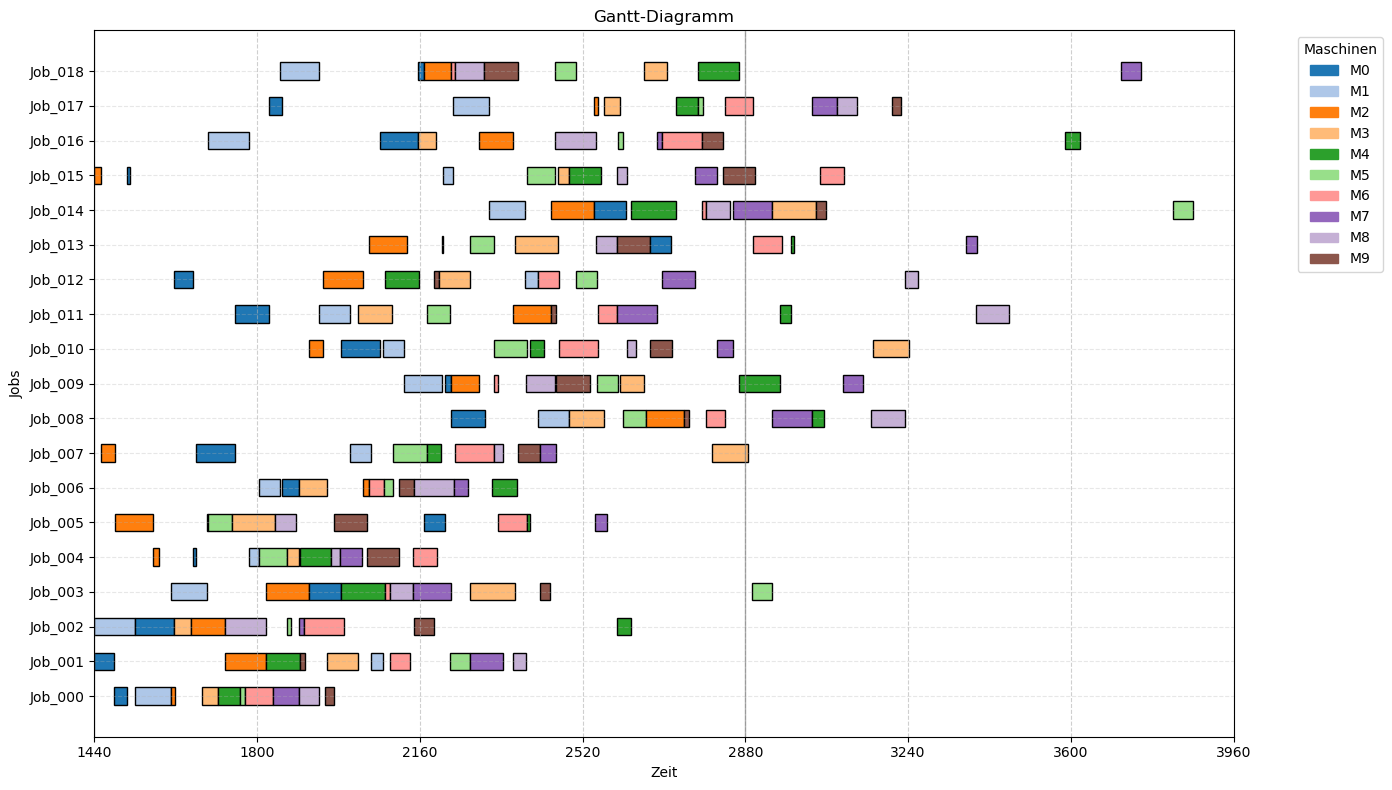

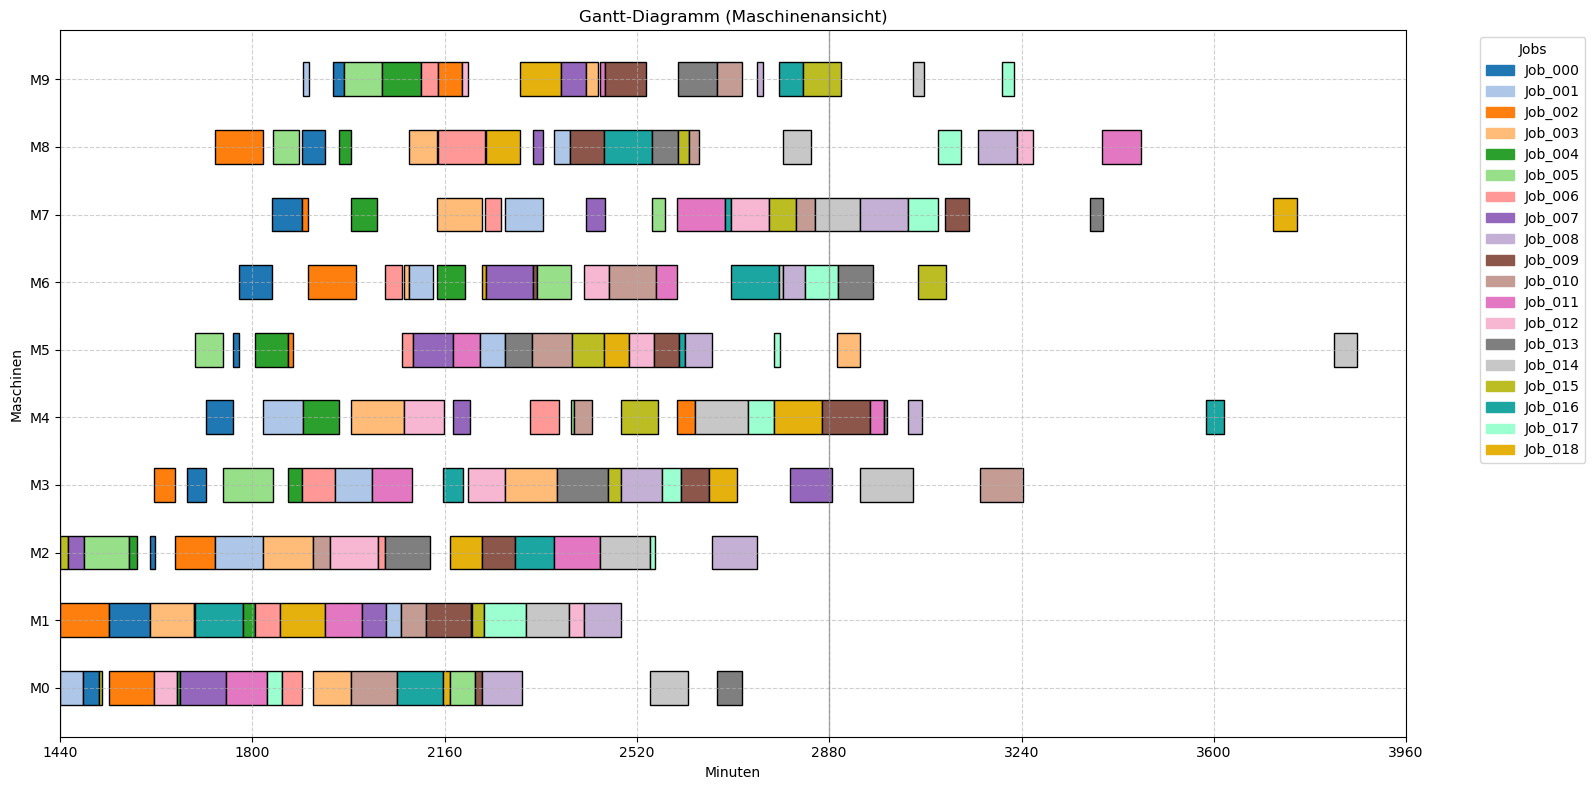

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [27]:
show.plot_gantt_jobs(df_plan)
show.plot_gantt_machines(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

In [28]:
last_ops = df_plan.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
show.count_column_grouped(last_ops, "Lateness", max_val = 360, steps= 60)

label
<-360           0
-360 - -300     0
-300 - -240     0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         1
0              18
0 - 60          0
60 - 120        0
120 - 180       0
180 - 240       0
240 - 300       0
300 - 360       0
>360            0
Name: count, dtype: int32

In [29]:
last_ops 

,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Tardiness,Earliness
50,Job_000,9,0,1971,M9,1950,21,1971,0,0,0
108,Job_001,9,83,2395,M8,2365,30,2395,0,0,0
138,Job_002,9,144,2628,M4,2595,33,2628,0,0,0
169,Job_003,9,197,2938,M5,2895,43,2938,0,0,0
75,Job_004,9,233,2198,M6,2145,53,2198,0,0,0
133,Job_005,9,302,2573,M7,2548,25,2573,0,0,0
103,Job_006,9,340,2374,M4,2319,55,2374,0,0,0
163,Job_007,9,488,2886,M3,2807,79,2886,0,0,0
181,Job_008,9,708,3278,M8,3158,74,3232,-46,0,46
180,Job_009,9,740,3141,M7,3096,45,3141,0,0,0


### Simulation

In [31]:
filt = (df_plan.Start < day_end)
df_plan_for_sim = df_plan[filt]
df_plan_for_sim

,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_001,0,83,2395,M0,1440,43,1483,-912,0,912
1,Job_002,0,144,2628,M1,1440,91,1531,-1097,0,1097
2,Job_015,0,1134,3099,M2,1440,14,1454,-1645,0,1645
3,Job_007,0,488,2886,M2,1454,31,1485,-1401,0,1401
4,Job_000,0,0,1971,M0,1483,29,1512,-459,0,459
...,...,...,...,...,...,...,...,...,...,...,...
164,Job_010,8,845,3242,M7,2817,36,2853,-389,0,389
165,Job_015,8,1134,3099,M9,2830,72,2902,-197,0,197
166,Job_017,6,1254,3225,M6,2834,62,2896,-329,0,329
167,Job_014,6,1128,3869,M7,2853,85,2938,-931,0,931


In [32]:
simulation = ProductionDaySimulation(df_plan_for_sim, vc=0.35)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[24:00:00] Job_001 started on M0
[24:00:00] Job_002 started on M1
[24:00:00] Job_015 started on M2
[24:17:18] Job_015 finished on M2 (after 17 minutes 19 seconds)
[24:17:18] Job_007 started on M2
[24:35:19] Job_001 finished on M0 (after 35 minutes 20 seconds)
[24:38:09] Job_007 finished on M2 (after 20 minutes 51 seconds)
[24:43:00] Job_000 started on M0
[24:45:00] Job_005 started on M2
[24:56:12] Job_000 finished on M0 (after 13 minutes 12 seconds)
[25:12:00] Job_015 started on M0
[25:20:15] Job_015 finished on M0 (after 08 minutes 15 seconds)
[25:37:14] Job_002 finished on M1 (after 97 minutes 14 seconds)
[25:37:14] Job_000 started on M1
[25:37:14] Job_002 started on M0
[26:13:47] Job_005 finished on M2 (after 88 minutes 48 seconds)
[26:13:47] Job_004 started on M2
[26:32:58] Job_004 finished on M2 (after 19 minutes 10 seconds)
[26:42:42] Job_002 finished on M0 (after 65 minutes 28 seconds)
[26:56:00] Job_012 started on M0
[26:56:00] Job_002 started on M3
[27:18:35] Job_000 finished 

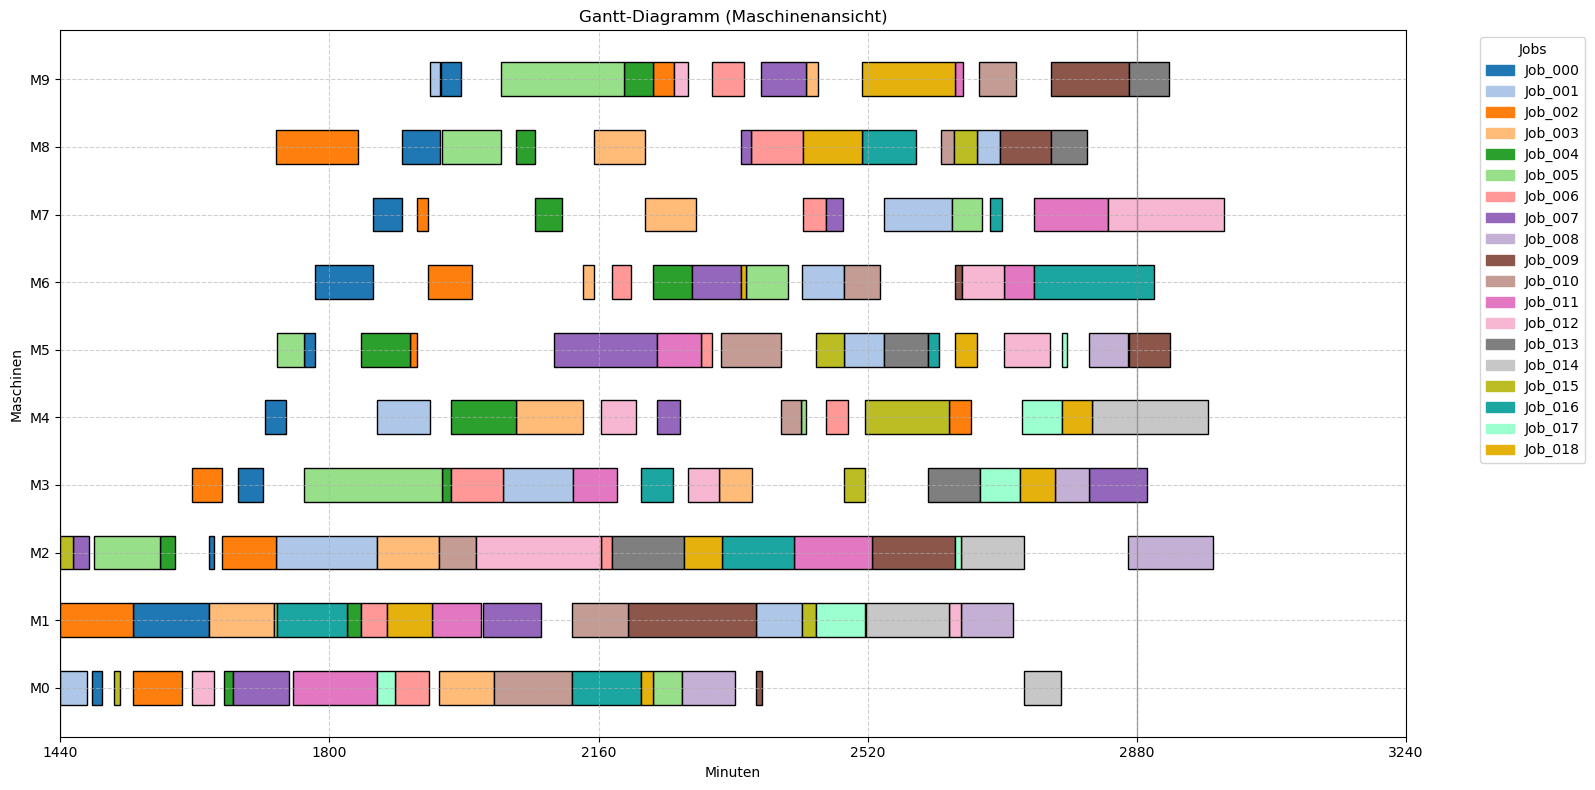

In [33]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution, duration_column="Simulated Processing Time")
else:
    print(f"Nothing executed on day {day_numb}")

In [34]:
df_undone.sort_values(by="Arrival")

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
2,Job_008,5,708,M9,2745,11
6,Job_008,6,708,M6,2794,40
0,Job_009,7,740,M3,2603,52
12,Job_009,8,740,M4,2866,90
8,Job_010,8,845,M7,2817,36
1,Job_013,6,1123,M0,2669,47
4,Job_014,4,1128,M6,2785,9
7,Job_014,5,1128,M8,2794,52
11,Job_014,6,1128,M7,2853,85
3,Job_015,7,1134,M7,2768,49


In [35]:
df_plan.to_csv(get_schedule_filename("06b_", day=day_numb, suffix="init"), index = False)

In [36]:
df_plan_init = df_plan
df_execution_init = df_execution
df_undone_init = df_undone

## A) Rolling Planning Simple

**Zielfunktion:**

Minimiere die gewichtete Summe aus Tardiness und Earliness der Jobs:

\\[
Z(\sigma) = \sum_{j} \left( w_t \cdot \text{Tardiness}_j + w_e \cdot \text{Earliness}_j \right)
\\]

wobei:

- \\( w_t \in \mathbb{N},\ w_e \in \mathbb{N} \\): Gewicht für Tardiness und Earliness  
- \\( \text{Tardiness}_j = \max(0, C_j - d_j) \\), \\( \text{Earliness}_j = \max(0, d_j - C_j) \\)  
    - \\( C_j \\): Fertigstellungszeitpunkt der letzten Operation von Job \\( j \\)  
    - \\( d_j \\): Deadline für Job \\( j \\)

In [39]:
day_start = 1440

In [40]:
df_plan_prev = df_plan_init

filt = (df_plan_prev.Start >= day_start)
df_plan_prev_important = df_plan_prev[filt]
df_plan_prev_important

,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_001,0,83,2395,M0,1440,43,1483,-912,0,912
1,Job_002,0,144,2628,M1,1440,91,1531,-1097,0,1097
2,Job_015,0,1134,3099,M2,1440,14,1454,-1645,0,1645
3,Job_007,0,488,2886,M2,1454,31,1485,-1401,0,1401
4,Job_000,0,0,1971,M0,1483,29,1512,-459,0,459
...,...,...,...,...,...,...,...,...,...,...,...
185,Job_013,9,1123,3393,M7,3368,25,3393,0,0,0
186,Job_011,9,894,3464,M8,3390,74,3464,0,0,0
187,Job_016,9,1135,3619,M4,3586,33,3619,0,0,0
188,Job_018,9,1354,3755,M7,3710,45,3755,0,0,0


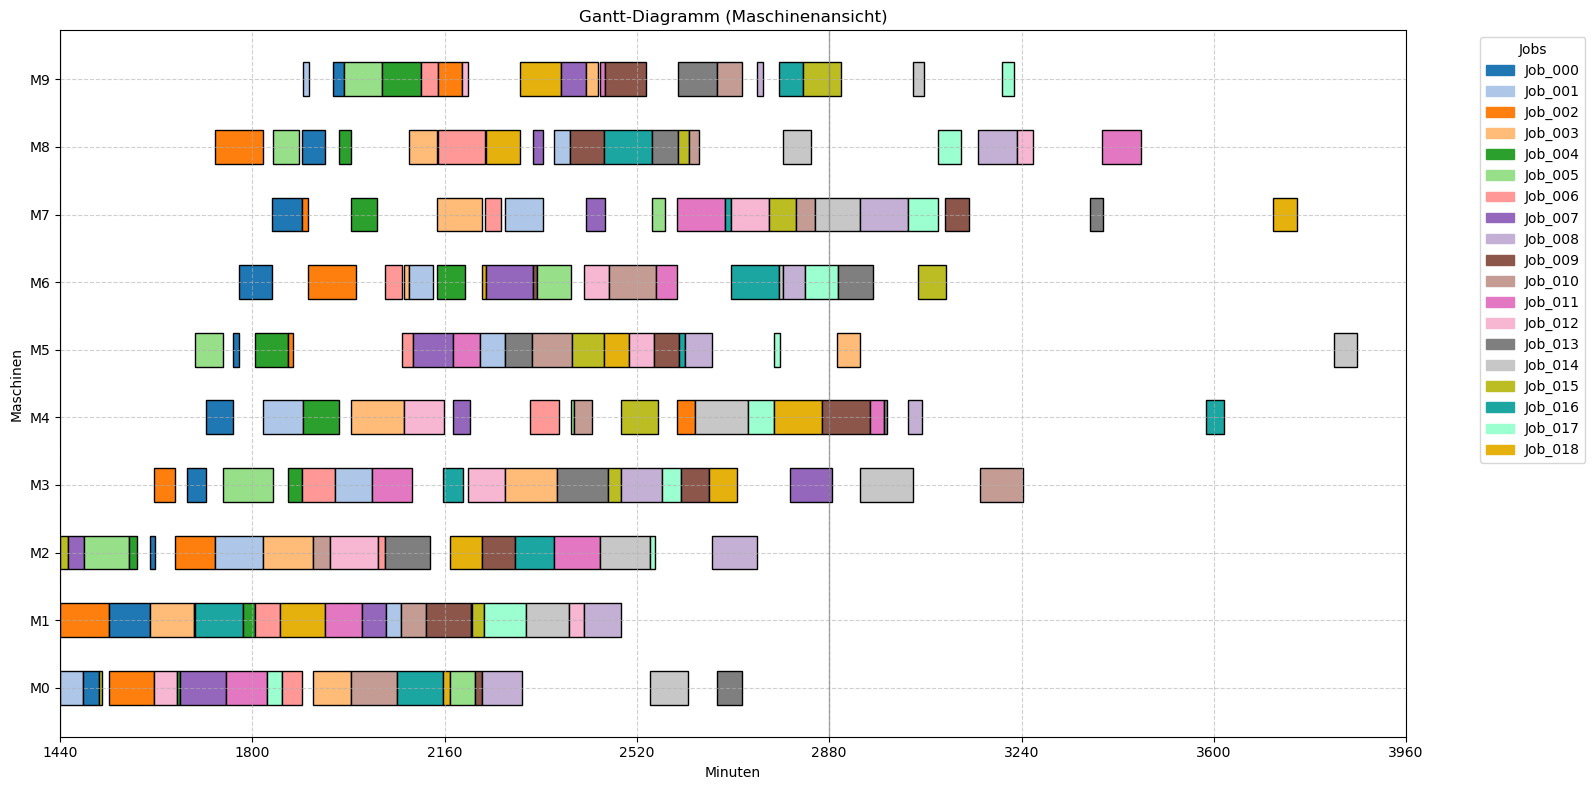

In [41]:
show.plot_gantt_machines(df_plan_prev_important)


Solver-Status         : OPTIMAL
Objective Value       : 1415.00
Best Objective Bound  : 1415.00
Laufzeit              : 14.97 Sekunden

  Scheduling-Dauer: 0 Minuten und 15.13 Sekunden.


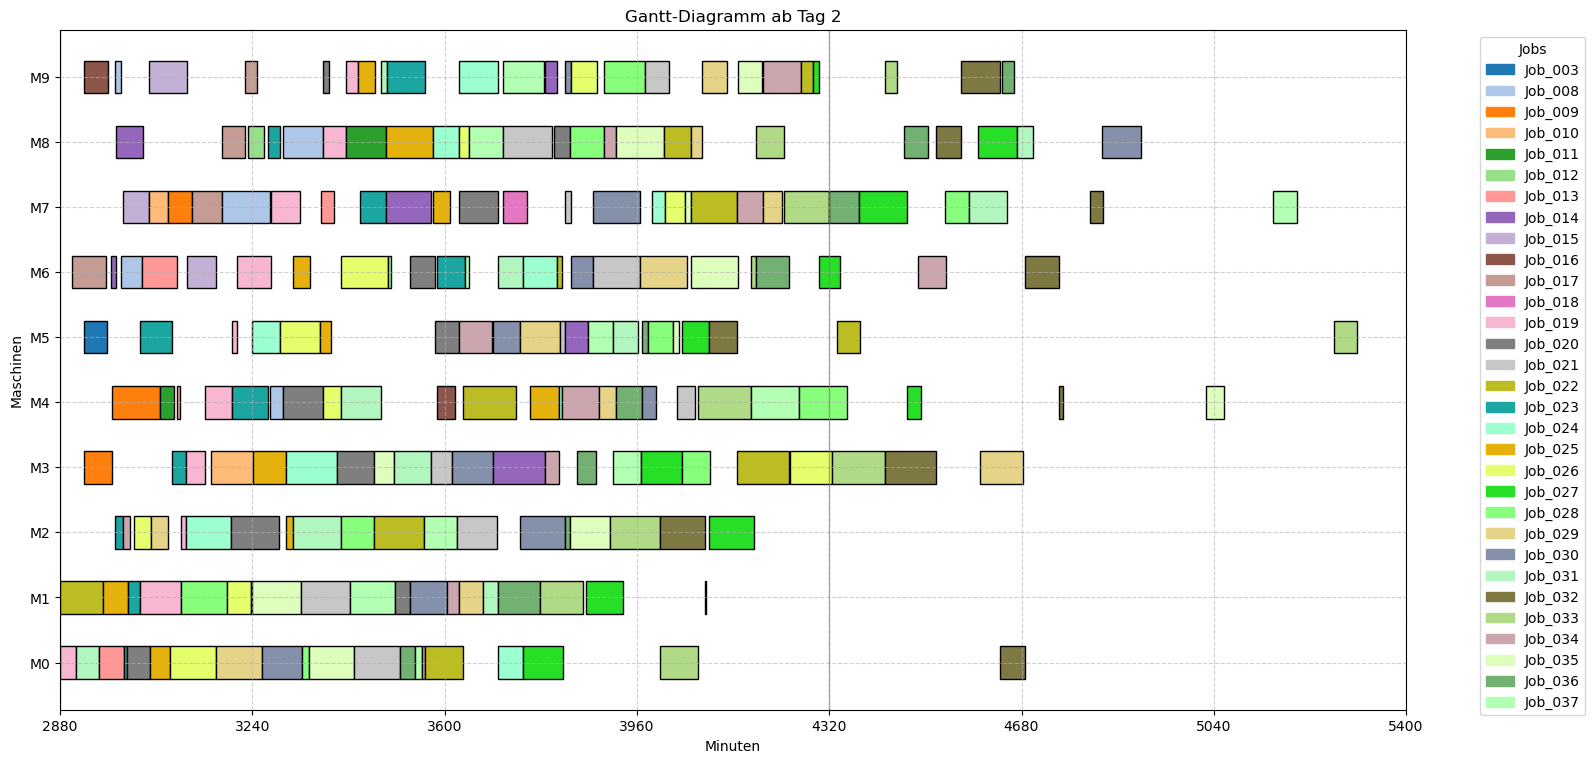

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         2
0              23
0 - 60          4
60 - 120        2
120 - 180       0
>180            0
Name: count, dtype: int32
[48:00:00] Job_019 started on M0
[48:00:00] Job_022 started on M1
[48:23:00] Job_017 started on M6
[48:42:58] Job_019 finished on M0 (after 42 minutes 58 seconds)
[48:42:58] Job_031 started on M0
[48:44:00] Job_016 started on M9
[48:45:00] Job_003 started on M5
[48:45:00] Job_009 started on M3
[48:47:14] Job_022 finished on M1 (after 47 minutes 14 seconds)
[49:04:46] Job_031 finished on M0 (after 21 minutes 48 seconds)
[49:09:52] Job_009 finished on M3 (after 24 minutes 52 seconds)
[49:12:00] Job_013 started on M0
[49:14:20] Job_016 finished on M9 (aft

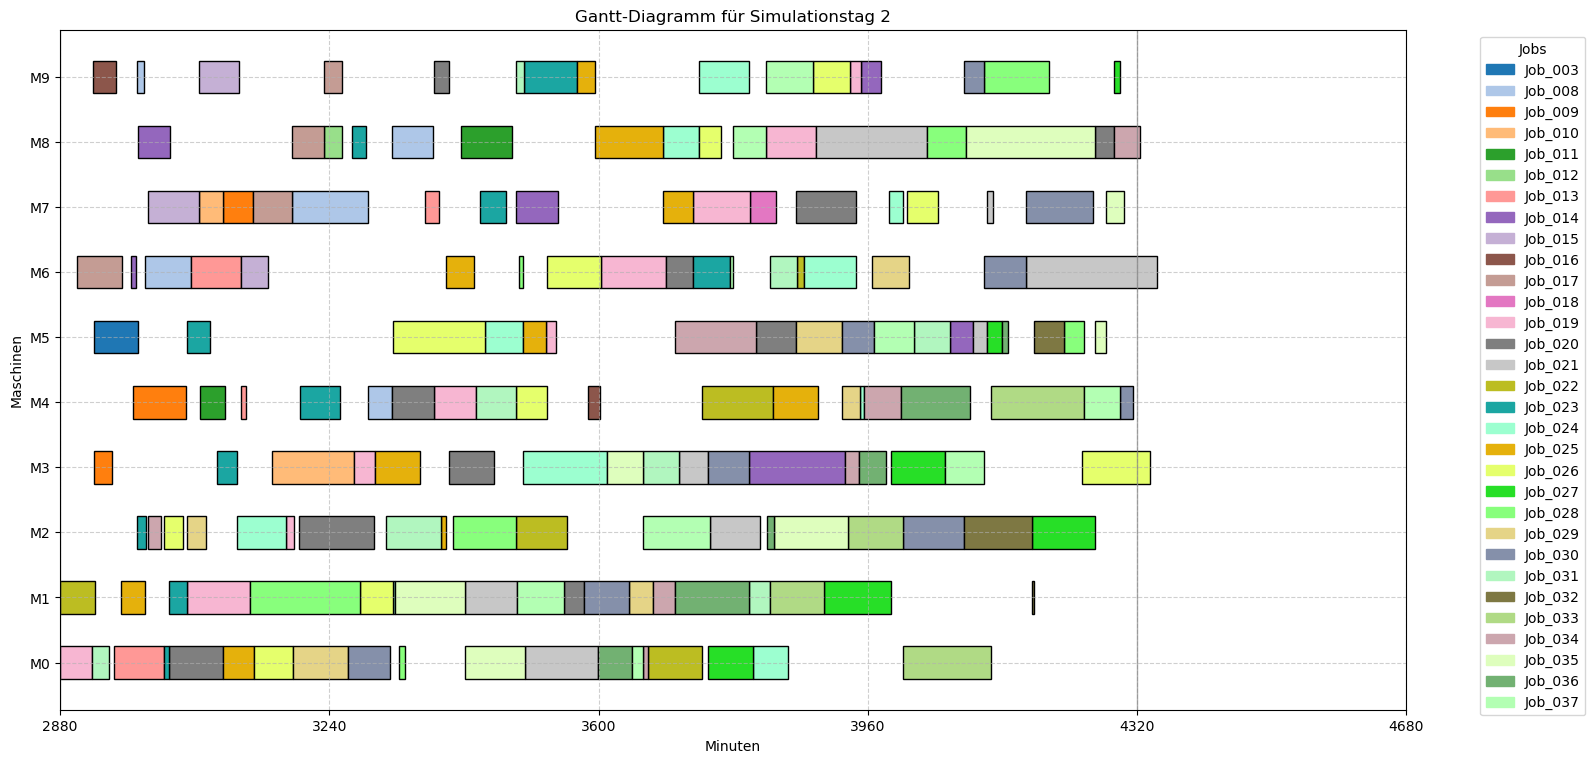

Not executed operations: 20
----------------------------------------------------------------------

Solver-Status         : OPTIMAL
Objective Value       : 4611.00
Best Objective Bound  : 4611.00
Laufzeit              : 71.41 Sekunden

  Scheduling-Dauer: 1 Minuten und 11.57 Sekunden.


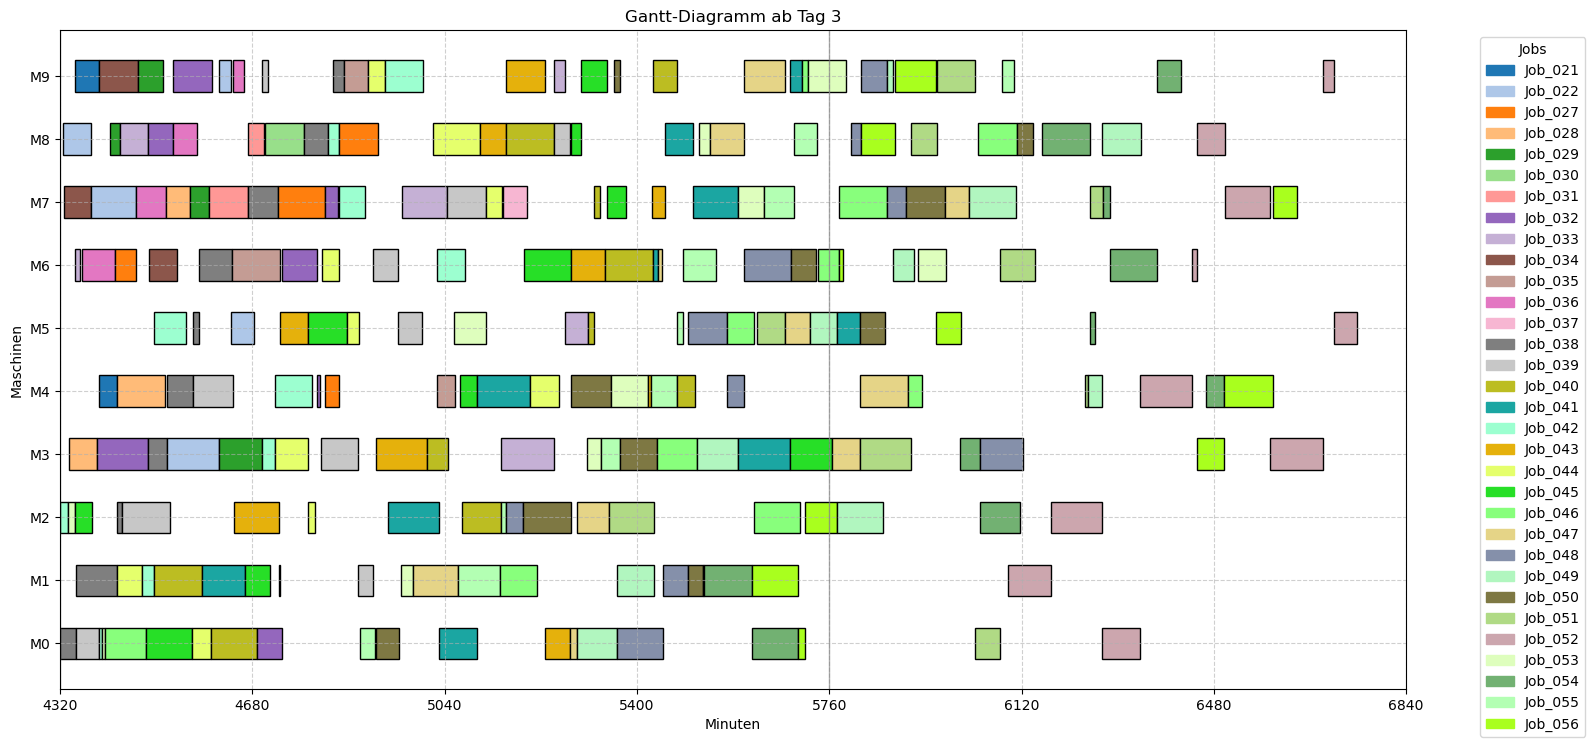

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     1
-120 - -60      0
-60 - 0         2
0              24
0 - 60          2
60 - 120        0
120 - 180       0
>180            3
Name: count, dtype: int32
[72:00:00] Job_038 started on M0
[72:00:00] Job_042 started on M2
[72:05:00] Job_022 started on M8
[72:08:00] Job_034 started on M7
[72:17:00] Job_028 started on M3
[72:21:19] Job_038 finished on M0 (after 21 minutes 20 seconds)
[72:24:21] Job_042 finished on M2 (after 24 minutes 21 seconds)
[72:24:21] Job_053 started on M2
[72:28:00] Job_021 started on M9
[72:28:00] Job_033 started on M6
[72:29:00] Job_039 started on M0
[72:29:00] Job_038 started on M1
[72:34:22] Job_053 finished on M2 (after 10 minutes 01 second)
[72:34:22] Job_045 started on M2
[72:

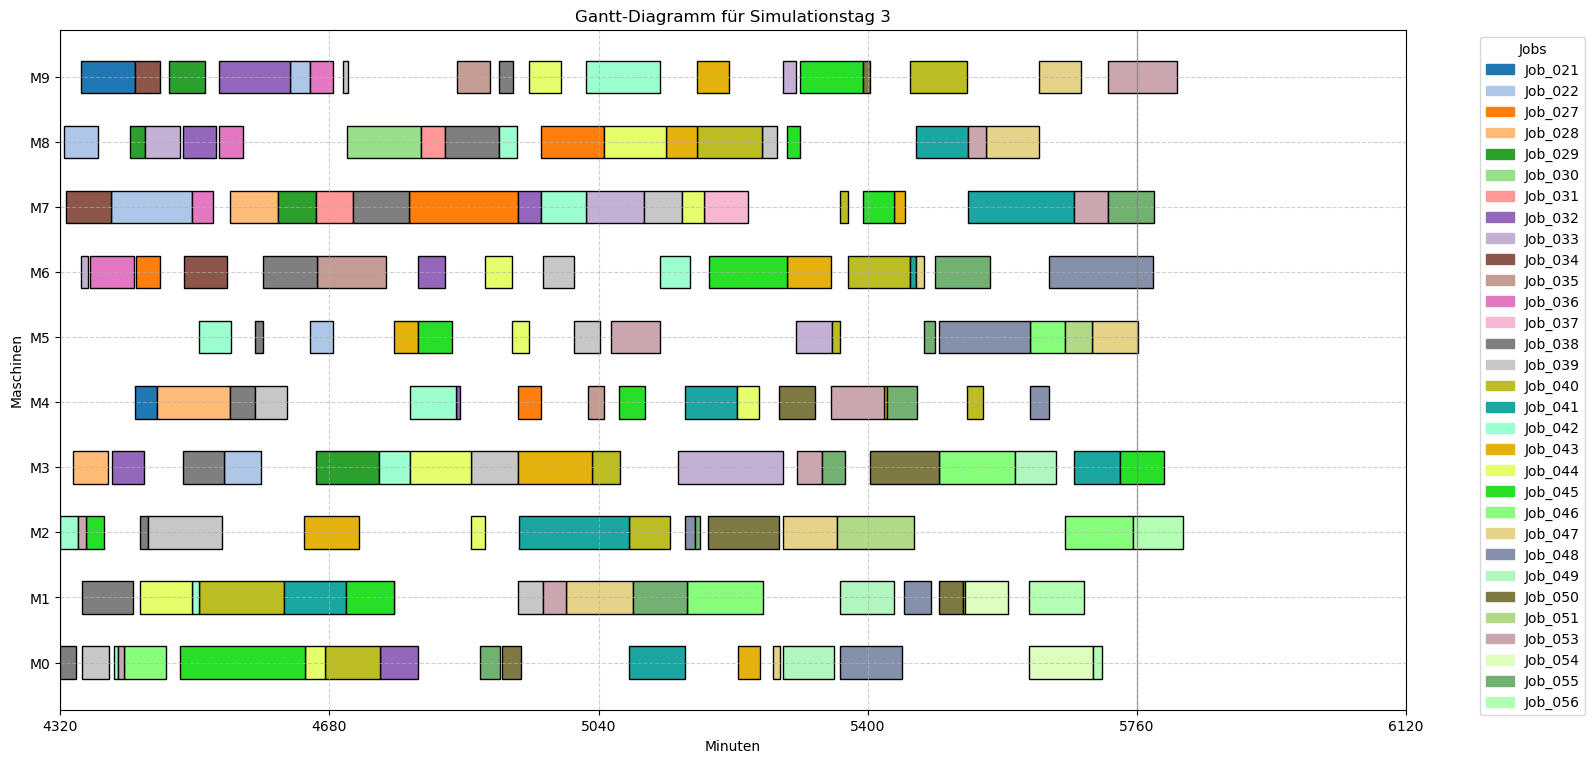

Not executed operations: 6
----------------------------------------------------------------------

Solver-Status         : OPTIMAL
Objective Value       : 634.00
Best Objective Bound  : 634.00
Laufzeit              : 14.54 Sekunden

  Scheduling-Dauer: 0 Minuten und 14.70 Sekunden.


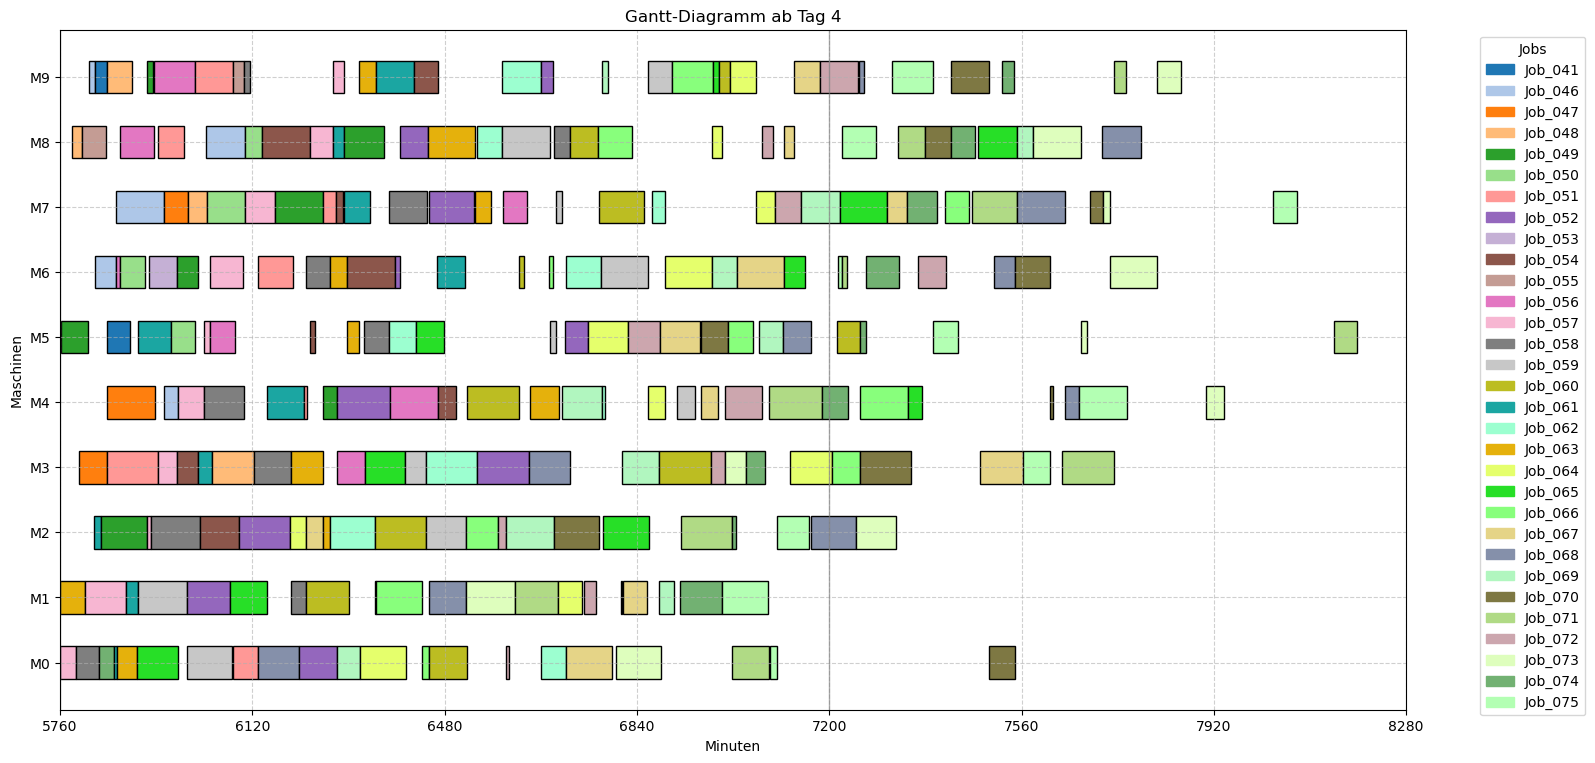

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         4
0              21
0 - 60          5
60 - 120        1
120 - 180       0
>180            0
Name: count, dtype: int32
[96:00:00] Job_057 started on M0
[96:00:00] Job_063 started on M1
[96:02:00] Job_049 started on M5
[96:16:33] Job_057 finished on M0 (after 16 minutes 34 seconds)
[96:22:00] Job_048 started on M8
[96:29:00] Job_058 started on M0
[96:34:01] Job_048 finished on M8 (after 12 minutes 02 seconds)
[96:36:00] Job_047 started on M3
[96:37:50] Job_049 finished on M5 (after 35 minutes 50 seconds)
[96:41:00] Job_055 started on M8
[96:54:00] Job_046 started on M9
[96:59:15] Job_063 finished on M1 (after 59 minutes 15 seconds)
[96:59:15] Job_057 started on M1
[97:0

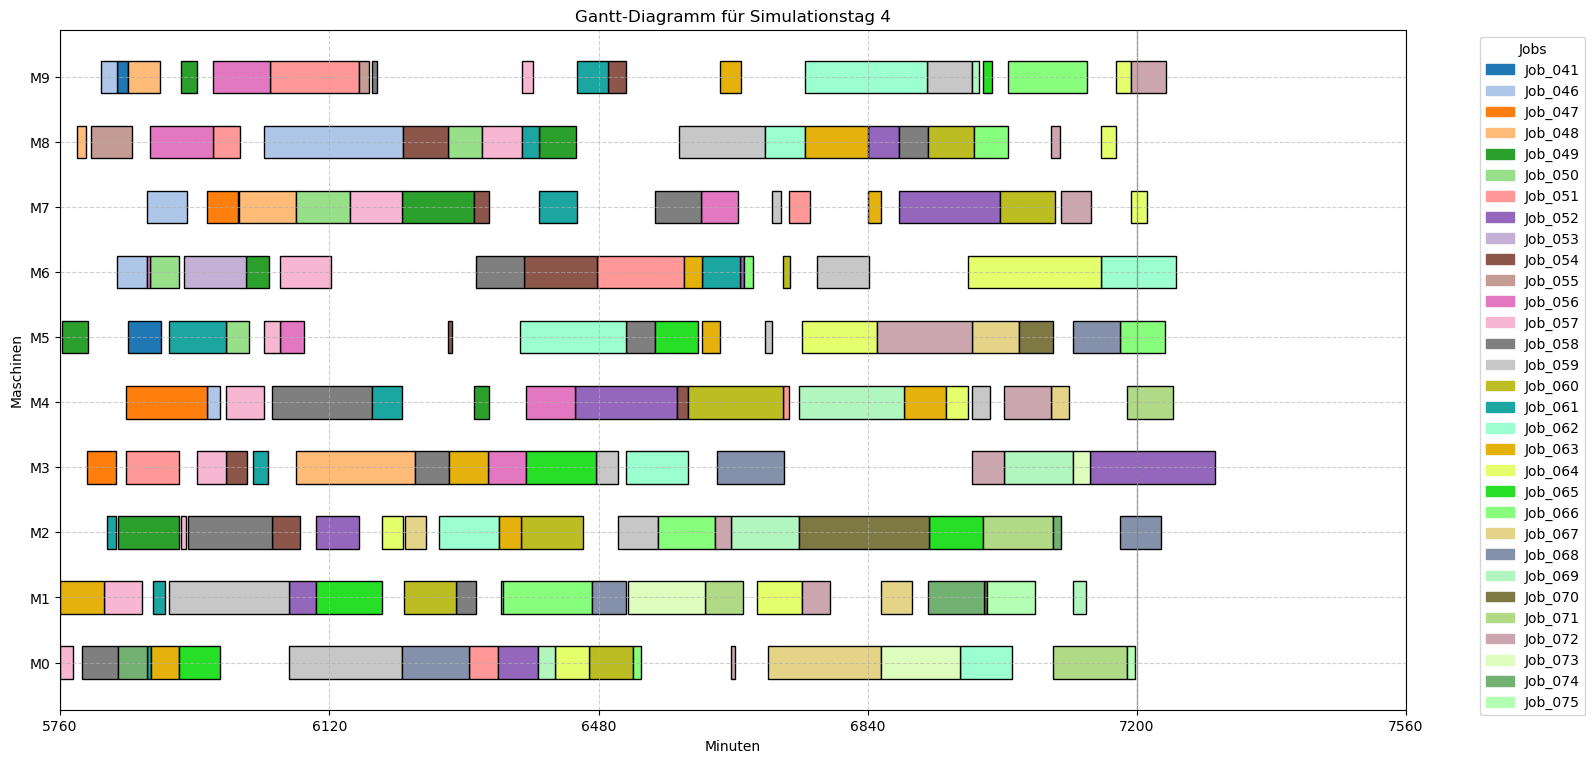

Not executed operations: 17
----------------------------------------------------------------------


In [ ]:
prefix_name = "06b_simple"

first_start = 2
last_planning_start = 7

df_plan = df_plan_init
df_execution = df_execution_init
df_undone = df_undone_init

for day_numb in range(first_start, last_planning_start + 1):
    day_start = day_length * day_numb
    day_end = day_start + day_length

    prev_day_start = day_start - day_length
    prev_day_end = day_end - day_length

    # ------------------- I. Ankunfts- und Operationsvorbereitung -------------------
    df_jssp_curr, df_times_curr = rp_proced.filter_jobs_by_arrival_window(df_times, df_jssp, prev_day_start , prev_day_end)
    df_jssp_curr = rp_proced.extend_with_undone_operations(df_jssp_curr, df_undone)
    df_times_curr = rp_proced.update_times_after_operation_changes(df_times, df_jssp_curr)

    # ------------------- II. Relevante laufende Operationen -------------------------
    df_execution_important = rp_proced.get_operations_running_into_day(df_execution, day_start)

    # ------------------- IIb. Relevante unsprünglich eingeplannte Operationen ------- (uneinplant, da nicht in Sim)

    df_jssp_curr = rp_proced.extend_operations_starting_today_plus(df_jssp_curr, df_plan, day_start)
    df_times_curr = rp_proced.update_times_after_operation_changes(df_times, df_jssp_curr)
    
    # ------------------- III. Rescheduling durchführen -------------------------------

    starting_time = time.time()
    df_plan = rssv.solve_cp_jssp_lateness_by_tardiness_and_earliness_with_fixed_ops(df_jssp_curr, df_times_curr, df_execution_important,
                                                                                    w_t = 5, reschedule_start = day_start, 
                                                                                    msg=False, timeLimit=max_time, gapRel= 0)

    
    solver_duration = time.time() - starting_time
    print(f"\n  Scheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")

    df_plan.to_csv(get_schedule_filename(prefix_name, day=day_numb), index=False)

    show.plot_gantt_machines(df_plan, title=f"Gantt-Diagramm ab Tag {day_numb}")
    check.check_constraints(df_plan)

    last_ops = df_plan.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
    print(show.count_column_grouped(last_ops, "Lateness", max_val = 180, steps= 60))

    # ------------------- IV. Einen Tag simulieren -------------------------------------
    filt = (df_plan.Start < day_end)
    df_plan_for_sim = df_plan[filt]
    
    simulation = ProductionDaySimulation(df_plan_for_sim, vc=0.35)
    df_execution, df_undone = simulation.run(start_time=day_start, end_time=day_end)
    if not df_execution.empty:
        show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm für Simulationstag {day_numb}", duration_column="Simulated Processing Time")
    else:
        print(f"Nothing executed on day {day_numb}")
        
    n_undone = len(df_undone)
    print(f"Not executed operations: {n_undone}")
    print("-" * 70)

## B) Rolling Planning mit "Deviation Penalty"

**Zielfunktion:**

Minimiere die gewichtete Summe aus Tardiness, Earliness und Abweichung vom ursprünglichen Startzeitpunkt (Deviation):

\\[
Z = r \cdot \sum_{j} \left( w_t \cdot \text{Tardiness}_j + w_e \cdot \text{Earliness}_j \right) + (1 - r) \cdot \sum_{j,o} \left| S_{jo} - S_{jo}^{\text{original}} \right|
\\]

wobei:

- \\( r \in [0,\ 1] \\): Gewichtung zwischen Termintreue und Planstabilität  
- \\( w_t \in \mathbb{N},\ w_e \in \mathbb{N} \\): Gewicht für Tardiness und Earliness  
- \\( \text{Tardiness}_j = \max(0, C_j - d_j) \\), \\( \text{Earliness}_j = \max(0, d_j - C_j) \\)  
    - \\( C_j \\) ist das Fertigstellungsdatum des letzten Schritts von Job \\( j \\)  
    - \\( d_j \\) ist die Deadline für Job \\( j \\)  
- \\( S_{jo} \\) ist der Startzeitpunkt der \\( o \\)-ten Operation von Job \\( j \\)  
- \\( S_{jo}^{\text{original}} \\) ist der ursprünglich geplante Startzeitpunkt

In [ ]:
from ortools.sat.python import cp_model
import pandas as pd
import math

def solve_cp_jssp_lateness_by_tardiness_and_earliness_with_devpen(
    df_jssp: pd.DataFrame,
    df_arrivals_deadlines: pd.DataFrame,
    df_executed: pd.DataFrame,
    df_original_plan: pd.DataFrame,
    w_t: int = 5,
    w_e: int = 1,
    r: float = 0.5,
    reschedule_start: float = 1440.0,
    sort_ascending: bool = False,
    msg: bool = False,
    timeLimit: int = 3600,
    gapRel: float = 0.0
) -> pd.DataFrame:
    """
    Solves a Job-Shop Scheduling Problem using Constraint Programming with:
    - weighted tardiness,
    - earliness,
    - deviation penalty from a given reference plan (df_original_plan).

    Only deviations for operations present in both df_jssp and df_original_plan are considered.

    Parameters:
        df_jssp: Job-Shop structure with ['Job','Operation','Machine','Processing Time']
        df_arrivals_deadlines: Arrival and Deadline info per Job
        df_executed: Already executed operations
        df_original_plan: Reference plan with original start times
        w_t, w_e: Weights for tardiness and earliness
        r: Relative weight between lateness and deviation (0–1)
        reschedule_start: Planning starts from this time onward
        sort_ascending: Sort jobs by deadline ascending (default: False)
        msg: Verbose solver output
        timeLimit: Max solver time in seconds
        gapRel: Relative gap limit

    Returns:
        df_schedule: A DataFrame with scheduled operations and timing info
    """

    model = cp_model.CpModel()
    w_t = int(w_t)
    w_e = int(w_e)
    r_scaled = int(round(r * 100))  # scaled for integer arithmetic

    # === Vorbereitung: Ankunft, Deadline, Jobliste ===
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # === Relevante Deviation-Paare bestimmen ===
    deviation_relevant_ops = set(
        df_jssp[["Job", "Operation"]].apply(tuple, axis=1)
    ) & set(
        df_original_plan[["Job", "Operation"]].apply(tuple, axis=1)
    )

    original_start = {
        (row["Job"], row["Operation"]): int(round(row["Start"]))
        for _, row in df_original_plan.iterrows()
        if (row["Job"], row["Operation"]) in deviation_relevant_ops
    }

    # === Operationen strukturieren ===
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = int(row["Operation"])
            m = str(row["Machine"])
            d = int(round(row["Processing Time"]))
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    # === Planungshorizont abschätzen ===
    horizon = int(df_jssp["Processing Time"].sum() + max(deadline.values()))

    # === Fixierte Operationen berücksichtigen ===
    df_executed_fixed = df_executed[df_executed["End"] >= reschedule_start]
    fixed_ops = {
        m: list(grp[["Start", "End"]].itertuples(index=False, name=None))
        for m, grp in df_executed_fixed.groupby("Machine")
    }
    last_executed_end = df_executed.groupby("Job")["End"].max().to_dict()

    # === Variablen definieren ===
    starts, ends, intervals = {}, {}, {}
    weighted_terms = []
    deviation_terms = []

    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            suffix = f"{j}_{o}"
            start = model.NewIntVar(0, horizon, f"start_{suffix}")
            end = model.NewIntVar(0, horizon, f"end_{suffix}")
            interval = model.NewIntervalVar(start, d, end, f"interval_{suffix}")
            starts[(j, o)] = start
            ends[(j, o)] = end
            intervals[(j, o)] = (interval, m)

    # === Constraints und Zielterme ===
    for j, job in enumerate(jobs):
        last_op_index = len(all_ops[j]) - 1
        job_end = ends[(j, last_op_index)]

        # Lateness = End - Deadline
        lateness = model.NewIntVar(-horizon, horizon, f"lateness_{j}")
        model.Add(lateness == job_end - deadline[job])

        # Tardiness
        tardiness = model.NewIntVar(0, horizon, f"tardiness_{j}")
        model.AddMaxEquality(tardiness, [lateness, 0])
        term_tardiness = model.NewIntVar(0, horizon * w_t, f"term_tardiness_{j}")
        model.Add(term_tardiness == w_t * tardiness)
        weighted_terms.append(term_tardiness)

        # Earliness
        earliness = model.NewIntVar(0, horizon, f"earliness_{j}")
        model.AddMaxEquality(earliness, [-lateness, 0])
        term_earliness = model.NewIntVar(0, horizon * w_e, f"term_earliness_{j}")
        model.Add(term_earliness == w_e * earliness)
        weighted_terms.append(term_earliness)

        # Startzeitbedingungen
        model.Add(starts[(j, 0)] >= max(arrival[job], int(reschedule_start)))
        if job in last_executed_end:
            model.Add(starts[(j, 0)] >= int(math.ceil(last_executed_end[job])))

        # Technologische Reihenfolge
        for o in range(1, len(all_ops[j])):
            model.Add(starts[(j, o)] >= ends[(j, o - 1)])

        # Deviation: nur für relevante Ops
        for o, (op_id, _, _) in enumerate(all_ops[j]):
            key = (job, op_id)
            if key in original_start:
                dev = model.NewIntVar(0, horizon, f"dev_{j}_{o}")
                diff = model.NewIntVar(-horizon, horizon, f"diff_{j}_{o}")
                model.Add(diff == starts[(j, o)] - original_start[key])
                model.AddAbsEquality(dev, diff)
                deviation_terms.append(dev)

    # === Maschinenrestriktionen (inkl. fixierter Intervalle) ===
    for m in machines:
        machine_intervals = [interval for (j, o), (interval, mach) in intervals.items() if mach == m]
        for fixed_start, fixed_end in fixed_ops.get(m, []):
            start = math.floor(fixed_start)
            end = math.ceil(fixed_end)
            duration = end - start
            if duration > 0:
                fixed_interval = model.NewIntervalVar(start, duration, end, f"fixed_{m}_{end}")
                machine_intervals.append(fixed_interval)
        model.AddNoOverlap(machine_intervals)

    # === Zielfunktion kombinieren ===
    weighted_part = model.NewIntVar(0, horizon * len(weighted_terms), "weighted_part")
    deviation_part = model.NewIntVar(0, horizon * len(deviation_terms), "deviation_part")
    model.Add(weighted_part == sum(weighted_terms))
    model.Add(deviation_part == sum(deviation_terms))

    total_cost = model.NewIntVar(0, horizon * len(jobs) * 100, "total_cost")
    model.Add(total_cost == r_scaled * weighted_part + (100 - r_scaled) * deviation_part)
    model.Minimize(total_cost)

    # === Solver-Einstellungen ===
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = msg
    solver.parameters.max_time_in_seconds = timeLimit
    solver.parameters.relative_gap_limit = gapRel
    status = solver.Solve(model)

    # === Ergebnis extrahieren ===
    records = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        for j, job in enumerate(jobs):
            for o, (op_id, m, d) in enumerate(all_ops[j]):
                st = solver.Value(starts[(j, o)])
                ed = st + d
                lateness_val = ed - deadline[job]
                records.append({
                    "Job": job,
                    "Operation": op_id,
                    "Arrival": arrival[job],
                    "Deadline": deadline[job],
                    "Machine": m,
                    "Start": st,
                    "Processing Time": d,
                    "End": ed,
                    "Lateness": lateness_val,
                    "Tardiness": max(0, lateness_val),
                    "Earliness": max(0, -lateness_val)
                })

        df_schedule = pd.DataFrame.from_records(records).sort_values(["Start", "Job", "Operation"]).reset_index(drop=True)
    else:
        print(f"\nSolver-Status         : {solver.StatusName(status)}")
        print("No feasible solution found!")
        df_schedule = pd.DataFrame()

    # === Logging ===
    print(f"\nSolver-Status         : {solver.StatusName(status)}")
    print(f"Objective Value       : {solver.ObjectiveValue():.2f}")
    print(f"Best Objective Bound  : {solver.BestObjectiveBound():.2f}")
    print(f"Laufzeit              : {solver.WallTime():.2f} Sekunden")
    print(f"Deviation terms       : {len(deviation_terms)}")

    return df_schedule


In [ ]:
prefix_name = "06b_devpen"
first_start = 2
last_planning_start = 7

df_plan = df_plan_init

df_execution = df_execution_init
df_undone = df_undone_init


for day_numb in range(first_start, last_planning_start + 1):
    day_start = day_length * day_numb
    day_end = day_start + day_length

    prev_day_start = day_start - day_length
    prev_day_end = day_end - day_length

    # ------------------- I. Ankunfts- und Operationsvorbereitung -------------------
    df_jssp_curr, df_times_curr = rp_proced.filter_jobs_by_arrival_window(df_times, df_jssp, prev_day_start, prev_day_end)
    df_jssp_curr = rp_proced.extend_with_undone_operations(df_jssp_curr, df_undone)
    df_times_curr = rp_proced.update_times_after_operation_changes(df_times, df_jssp_curr)

    # ------------------- IIa. Relevante laufende Operationen -------------------------
    df_execution_important = rp_proced.get_operations_running_into_day(df_execution, day_start)

    # ------------------- IIb. Relevante unsprünglich eingeplannte Operationen -------- (uneingeplant, da nicht in Sim)

    # df_plan_prev_important = rp_proced.get_operations_starting_today_plus(df_plan, day_start) # es fehlen noch die unerledigten
    df_plan_prev_important = df_plan # Devpen

    df_jssp_curr = rp_proced.extend_operations_starting_today_plus(df_jssp_curr, df_plan, day_start)
    df_times_curr = rp_proced.update_times_after_operation_changes(df_times, df_jssp_curr)
    
    # ------------------- III. Rescheduling durchführen -------------------------------

    starting_time = time.time()
    df_plan = solve_cp_jssp_lateness_by_tardiness_and_earliness_with_devpen(df_jssp_curr, df_times_curr, df_execution_important,
                                                                                 df_original_plan = df_plan_prev_important, # prev. Plan
                                                                                 w_t = 5,
                                                                                 r = 0.70, # 70% Lateness, 30% Deviation
                                                                                 reschedule_start = day_start,
                                                                                 msg=False, timeLimit=max_time, gapRel= 0.01)

    
    solver_duration = time.time() - starting_time
    print(f"\n  Scheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")

    df_plan.to_csv(get_schedule_filename(prefix_name, day=day_numb), index=False)

    show.plot_gantt_machines(df_plan, title=f"Gantt-Diagramm ab Tag {day_numb}")
    check.check_constraints(df_plan)

    last_ops = df_plan.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
    print(show.count_column_grouped(last_ops, "Lateness", max_val = 180, steps= 60))

    # ------------------- IV. Einen Tag simulieren -------------------------------------
    filt = (df_plan.Start < day_end)
    df_plan_for_sim = df_plan[filt]
    
    simulation = ProductionDaySimulation(df_plan_for_sim, vc=0.35)
    df_execution, df_undone = simulation.run(start_time=day_start, end_time=day_end)
    if not df_execution.empty:
        show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm für Simulationstag {day_numb}", duration_column="Simulated Processing Time")
    else:
        print(f"Nothing executed on day {day_numb}")

    n_undone = len(df_undone)
    print(f"Not executed operations: {n_undone}")
    print("-" * 70)

In [ ]:
notebook_duration = time.time() - start_notebook
print(f"Dauer: {int(notebook_duration // 60)} Minuten und {(notebook_duration % 60):.2f} Sekunden.")